# 0. Overview

### Data

We will be analyzing an extract of 1994 U.S. Census data. See more on the data set [here](https://archive.ics.uci.edu/ml/datasets/census+income). First, we are going to need some help from some well-known, third-party libraries

### Goals

Work through the given data - cleaning it, exploring it, transforming it - so as to come to a point where we can build a model to predict whether or not a given citizen, based on the other available information, earns over $50K per year. Additionally, we will dive into learning the proper protocols for setting up for tuning, and evaluating, our predictive models. 

### Third-party libraries

Third-party libraries are libraries (collections of code) that do not come with the core Python distribution. You can get these libraries through downloading the Anaconda distribution, which includes them all, or through installing them manually with `pip` (or `pip3`, depending on your system), which is the Python package manager.

When importing a Python library, you can give it an alias, which is usually done to make something easier to type. It's good to follow standard protocol for a given library when doing this so that other people will recognize it throughout your code. 

`numpy` (typically abbreviated as `np`) provides the following:
- a homogenous (read: for a single data type) array with very useful manipulation methods
- a number of useful advanced math functions
- other data type helpers
- in many ways `numpy` is a collection of Python wrappers for very well-optimized C and FORTRAN math code

`pandas` (typically abbreviated as `pd`) is:
- a library that provides, amongst other things, a very nice data structure known as the `DataFrame`
- the `DataFrame` is a relational / tabular data structure
- i.e. it allows you to do SQL-ish analysis in Python
- it also visualizes nicely in Jupyter notebooks
- a good bit of Pandas is actually just user-friendly interfaces on top of `numpy`

`matplotlib` (from which the `pyplot` submodule is typically imported and aliased as `plt`)
- the old faithful data visualization library for Python
- it definitely provides a steep learning curve
- but it's a powerful tool once learned

`indoorplants`
- this is a library I've written to help me in my analysis workflows. You are welcome to check out and use the code, which you can find [here](https://github.com/lermana/indoorplants)
- to get this library, run `pip install indoorplants`
- you'll want to restart jupyter after doing this. so, you may want to go to the terminal (or cmd in Windows) where you are running this notebook, kill jupyter (`ctl` + `c`, and then `y`, then `enter`) and then install the library, and then relaunch jupyter (`jupyter notebook`). you could also just use the anaconda installer app for this
- if you don't want the install, you can simply comment out the lines that mention that repo with a `#`; look for commands or functions that start with: `exploratory.`, `features.`, `crossvalidate.`, `curves.`

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, chi2
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, make_scorer

from indoorplants.analysis import exploratory, features
from indoorplants.validation import crossvalidate, curves

### Taking notes in a `jupyter notebook`

The ability to intertermix well-formatted notes with your code and charts is one of the strongest features that `jupyer` offers its users. You can write notes with [markdown syntax](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet). Below is a an example markdown cell, which you can `enter` into to see how its formatting is created: 

**Example note taking**:
> Here is a *quote* 

We can write `code`, too:
```
def fake_func():
    return None
```

You can write math, too:
> $\sum n$

Here's a [link](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to more examples.

### Plots

In [2]:
%matplotlib inline

The above is a _magic_ Jupyter command that ensures all `matplotlib` plots will by default show in the notebook.

# 1. Get Data

### Retrieve and quick look

In [3]:
def get_census_data():
    # column names
    cols = ['age', 'workclass', 'fnlwgt', 'education', 
            'education_num', 'marital_status', 'occupation',
            'relationship', 'race', 'sex', 'capital_gain',
            'capital_loss', 'hours_per_week', 'native_country', 
            'over_fifty_k']

    # url to retrieve data from
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    
    # iterate through lines of data stream, decoding and splitting each line on commas
    print("Making request to get data.")

    with requests.get(url, stream=True) as r:
        results = [l.decode().split(',') for l in r.iter_lines()]

    print("Data retrieved.")
    
    # convert data from of list of lists to DataFrame, set columns, and return
    return pd.DataFrame(results, columns=cols)

Let's use the above function to retrieve our data:

In [4]:
table = get_census_data()

Making request to get data.
Data retrieved.


A great first step is to check out the size of your data:

In [5]:
table.shape

(32562, 15)

Next, let's look at data types. We can call the `dtypes` attribute on our `DataFrame` to see the data type for each of its columns. We'll then pass those results into the `value_counts` method, which returns all the values in the column it's called on, with the number of times that each value shows up in the column:

In [6]:
table.dtypes

age               object
workclass         object
fnlwgt            object
education         object
education_num     object
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain      object
capital_loss      object
hours_per_week    object
native_country    object
over_fifty_k      object
dtype: object

In [7]:
table.dtypes.value_counts()

object    15
dtype: int64

All data columns are currently formatted as _strings_ (which `pandas` represents with the `object` type), which we will have to handle accordingly. 

Let's actually _look_ quickly at the top and bottom of the table. We can do this through using `iloc`, which takes the _integer location_ of rows and columns to return:

In [8]:
table.iloc[:5, :7]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty


In [9]:
table.iloc[-5:, 8:]

,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
32557,White,Male,0,0,40,United-States,>50K
32558,White,Female,0,0,40,United-States,<=50K
32559,White,Male,0,0,20,United-States,<=50K
32560,White,Female,15024,0,40,United-States,>50K
32561,None,None,None,None,None,None,None


### Data cleanliness

Let's check for missing values:

In [10]:
table.isnull().sum()

age               0
workclass         1
fnlwgt            1
education         1
education_num     1
marital_status    1
occupation        1
relationship      1
race              1
sex               1
capital_gain      1
capital_loss      1
hours_per_week    1
native_country    1
over_fifty_k      1
dtype: int64

`isnull()` is a method that returns `True` for every row in `data` that is `null`, in each of the columns. We can then call `sum` on the results to see the total number of `null` values in each column.

We see that we have 1 missing value each, for every column except for `age` - let's see if these all these values are in the same row:

In [11]:
table[table.isnull().any(1)].index

Int64Index([32561], dtype='int64')

One of the ways in which we can filter a `DataFrame` is to pass a condition into it using square brackets.The square bracket syntax works such that it will then return the rows in the `DataFrame` that have a value of `True`. So, `isnull` returns a whole collection of `True` or `False` values for each position in the index, and the square bracket syntax then returns the rest of the row for each `True` index value. 

All missing values are in the row _labeled_ `32561`. Before we delete this row, let's see if the `age` column has any useful information in this row:

In [12]:
table.loc[32561, "age"]

''

Nothing - so let's drop. Note that dropping missing data is, generally speaking a bad idea. In this case, we have exactly _one_ out of over 30K+ rows that's missing, so, fine to just drop it. See more on the subject [here](http://www.stat.columbia.edu/~gelman/arm/missing.pdf).

In [13]:
table = table.dropna()

Now, let's check for duplicates:

In [14]:
table.duplicated().head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [15]:
table.duplicated().sum()

24

In [16]:
table[table.duplicated(keep=False)].sort_values(table.columns.to_list()).head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
6990,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
21318,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
15189,19,Private,146679,Some-college,10,Never-married,Exec-managerial,Own-child,Black,Male,0,0,30,United-States,<=50K
21490,19,Private,146679,Some-college,10,Never-married,Exec-managerial,Own-child,Black,Male,0,0,30,United-States,<=50K
3917,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,14,United-States,<=50K


In [17]:
table.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
over_fifty_k      0
dtype: int64

The `duplicated` method works similarly to `isnull`, in that it returns a _boolean mask_. By default, it will return `True` for a row that has _already_ been seen. You can control whether it treats the _first_ or _last_ instance of a row as a duplicate, or you can also count _all_ instances of a given row (that appears more than once) as duplicates. This behavior is controlled through the `keep` _keyword argument_. 

Let's write _all_ duplicates to file before we drop them. We can do this using the `to_csv` method, which takes (in addition to other optional parameters that control things like the delimiter used) a _path_ to write the file to:

In [18]:
table[table.duplicated(keep=False)].to_csv("duplicates.csv")

In [19]:
table = table.drop_duplicates()

### Data type handling - _numeric_

Let's get this data typed properly. We may have to manually make these changes using the `astype` method, but let's see what the `infer_objects` method can do for us:

In [20]:
table.infer_objects().dtypes

age               object
workclass         object
fnlwgt            object
education         object
education_num     object
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain      object
capital_loss      object
hours_per_week    object
native_country    object
over_fifty_k      object
dtype: object

Ok .... nothing. We'll try this manually.

We know that most of these columns contain _categorical_, or _non-numeric_ data, but a few of these are numeric. Let's take a closer look. 

Note that we can pass multiple columns to a `DataFrame` through the use of double brackets. Also note that we can use the `head` method to return the first five rows across all columns:

In [21]:
table[["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


Let's save these columns for future use:

In [22]:
numeric_cols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

It would be good to know whether we have _integer_ or _real_ number data in these numeric columns. How about we see if any of these columns _contain_ a `.`? `pandas` provides classic, Python string functionality to be applied to a `Series` of `object` type through accessing the `str` attribute, which we can make use of here.

A `Series` is a single column of a `DataFrame`. While there is _a lot_ of overlap between `DataFrame` and `Series` functionality, there are some differences, and we are seeing one here - the `str` attribute exists only at the column level; i.e. it doesn't exist across more than one column at a time, if that makes sense.

Let's start by checking our first numeric column to see whether there is a `.` in any of its values:

In [23]:
table[numeric_cols].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [24]:
numeric_cols[0]

'age'

In [25]:
table[numeric_cols[0]].head()

0    39
1    50
2    38
3    53
4    28
Name: age, dtype: object

In [26]:
table["age"].head()

0    39
1    50
2    38
3    53
4    28
Name: age, dtype: object

In [27]:
table.age.head()

0    39
1    50
2    38
3    53
4    28
Name: age, dtype: object

In [28]:
"This is a string in Python.".lower().replace(" ", "_").replace(".", "")

'this_is_a_string_in_python'

In [29]:
table[numeric_cols[0]].str.contains("\.").head()

0    False
1    False
2    False
3    False
4    False
Name: age, dtype: bool

In [30]:
table[numeric_cols[0]].str.contains("\.").sum()

0

A couple of things to note here:
- you cannot use `table.column`, and must use `table[column]`, when accessing a `DataFrame` column via a variable name
- you must _escape_ `.` with a backslash (othwerise it will be treated as a _regex_ pattern)

### --

### Problem

Check this across _all_ of our `numeric_cols`, through leveraging _iteration_. Bonus points if you can write this check as a one-liner.

### --

In [35]:
table.loc[:, numeric_cols].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [36]:
table[numeric_cols].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [37]:
table[numeric_cols] = table[numeric_cols].astype(int)

In [38]:
table[numeric_cols].head().dtypes

age               int64
fnlwgt            int64
education_num     int64
capital_gain      int64
capital_loss      int64
hours_per_week    int64
dtype: object

In [39]:
table.loc[:, numeric_cols] = table.loc[:, numeric_cols].astype(int)

In [40]:
table.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
over_fifty_k      object
dtype: object

In [41]:
table.loc[:, numeric_cols].astype(int).dtypes

age               int64
fnlwgt            int64
education_num     int64
capital_gain      int64
capital_loss      int64
hours_per_week    int64
dtype: object

In [42]:
table[numeric_cols].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [43]:
table.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
over_fifty_k      object
dtype: object

### --

### Data type handling - _boolean_

Let's take a closer look at what we're trying to predict - `over_fifty_k`:

In [44]:
table.over_fifty_k.head()

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: over_fifty_k, dtype: object

This doesn't look very nice, does it?

In [45]:
table.over_fifty_k.value_counts()

 <=50K    24698
 >50K      7839
Name: over_fifty_k, dtype: int64

So, this is really a `bool` variable, but we currently have it represented via this _ugly_ string. Let's fix that.

### --

### Problem

Re-engineer this as a `bool` column.

### --

### Data type handling - almost done

Let's take a look at what we've done so far:

In [51]:
table.dtypes.value_counts()

object    9
int64     6
bool      1
dtype: int64

We can actually make sub-selections on our table, by `dtype`:

In [52]:
table.select_dtypes(include=[int]).head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [53]:
table.select_dtypes(exclude=[object, int]).head()

,over_fifty_k_bool
0,False
1,False
2,False
3,False
4,False


Wait... before we progress - should we check all the other `object` columns to make sure they don't have the same issue as `over_fifty_k` did?

### --

### Problem

Check whether other `object` column values have issues with trailing and / or leading spaces, and try to make use of iteration and / or group selection.

### --

# 2. Exploratory Data Analysis

Exploratory data analysis (EDA) is key to understanding your data - this is where you poke around and see how things work.

### Numeric columns - _distributional analysis_

With numeric data, we often want to understand how it's _distributed_, i.e. the frequencies associated with different values in the data.

Let's start with `age`. We can see the number of unique values with the `nunique` method:

In [60]:
table.age.nunique()

73

We have a good number of values here, but this is still _discrete_ data, so we can actually use `value_counts` to analyze it.

In the following cell, we're going to go into `table`, get the `age` column, call `value_counts`, sort the index with the `sort_index` method (so that the ages are presented in _numerical_ order, as opposed order of frequency, which is how `value_counts` will return its results) and then we're going to call `plot`.

You can call (i.e. put parantheses after the function name) `plot` directly, which will produce a _line_ plot, or you can specify other types of plots. In this case, we're calling the `bar` method, which will give us a _bar graph_. I've passed some additional arguments to `bar` to control the _size_ of the figure, as well as the _color_ of the plot, and, finally, the rotation of the _x-axis_ labels.

The results of this procedure are the _axes_ of the plot, which can be used to further modify the plot. I'm using these _axes_ (stored in the variable `ax`) to set a title.

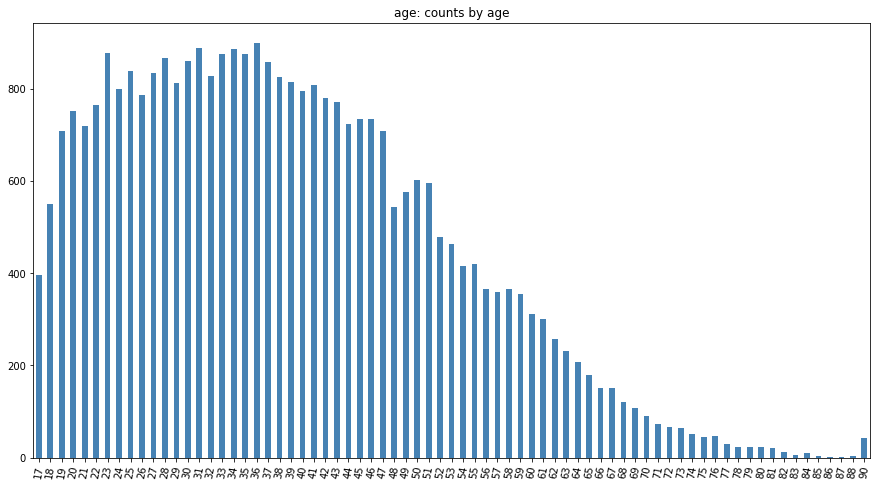

In [61]:
ax = table.age.value_counts().sort_index().plot.bar(figsize=(15, 8), color="steelblue", rot=80)
ax.title.set_text('age: counts by age')

They say a picture's worth a thousand words, and I think that adage undoubtedly holds true in data analysis.

Right off the bat, we can see here that there's an unusual spike at 90, which could indicate that all ages greater than or equal to 90 were simply bucketed.Additionally, we can that the 30s are probably the most well-represented decade in this data. 

Let's put some numbers behind these observations.

In [62]:
table.age.describe().to_frame()

,age
count,32537.000000
mean,38.585549
std,13.637984
min,17.000000
25%,28.000000
50%,37.000000
75%,48.000000
max,90.000000


The `describe` method gives us a number of descriptive stats. In order of appearance:
- number of non-null rows
- mean
- standard deviation
- minumum value in the data
- 25th percentile
- median
- 75th percentile
- maximum value in the data

Note that you can also call these functions individually:

In [63]:
table.age.mean()

38.585548759873376

In [64]:
table.age.quantile([.9, .95, .99, .999, .9999, .99999])

0.90000    58.0
0.95000    63.0
0.99000    74.0
0.99900    90.0
0.99990    90.0
0.99999    90.0
Name: age, dtype: float64

We can see that the average age (noting that this is not a _true_ average, due to binning at 90) is around 39. The fact that the median is a little bit lower than the average is a nod to this data's _positive- or right-skew_. We can also see that this data goes neither below 17 nor above 90.

`matploliblib` is a very powerful, if difficult-to-learn, tool. A deep dive into its functionality is outside the scope of this seminar, but to give you a sense of what it can do:

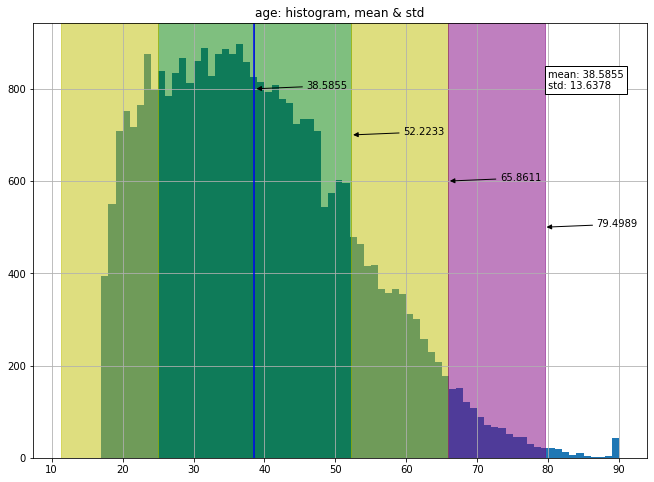

In [65]:
ax = exploratory.center_scale_plot(table.age, np.mean, np.std, bins=73)

In [66]:
def custom_round(x, base=5):
    return (base * round(x.astype(float)/base)).astype(int)

In [67]:
custom_round(table.age).head(10)

0    40
1    50
2    40
3    55
4    30
5    35
6    50
7    50
8    30
9    40
Name: age, dtype: int64

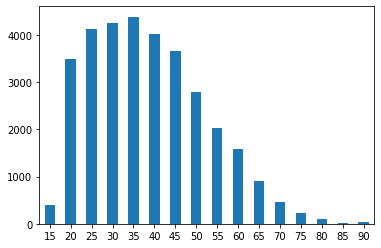

In [68]:
custom_round(table.age).value_counts().sort_index().plot.bar(rot=0)

This is interesting data, as it's got a hard cutoff at 17. Sometimes, when we see data that is very skewed, it can be helpful to take a transform of it. Taking the _logarithm_ of data will strongly reduce data. The _square root_ will reduce skew more gently. The _cube root_ transform works well when dealing with negative values.

Let's try the `log` function from `numpy`:

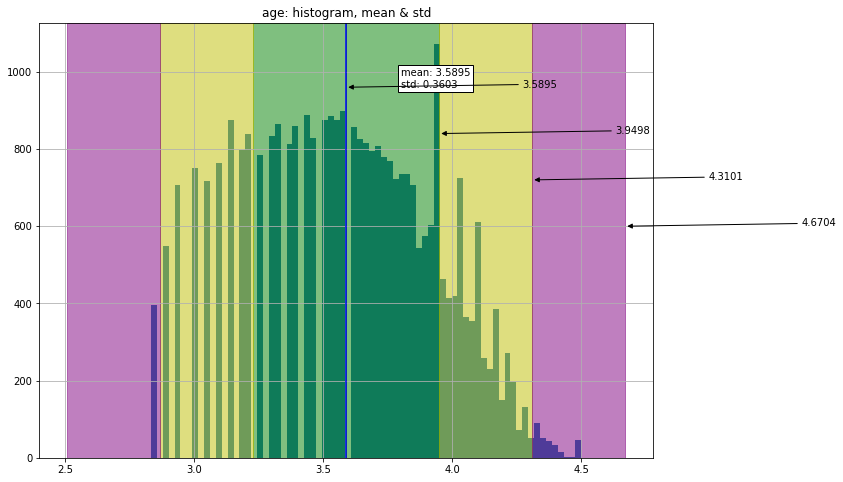

In [69]:
ax = exploratory.center_scale_plot(np.log(table.age), np.mean, np.std, bins=73)

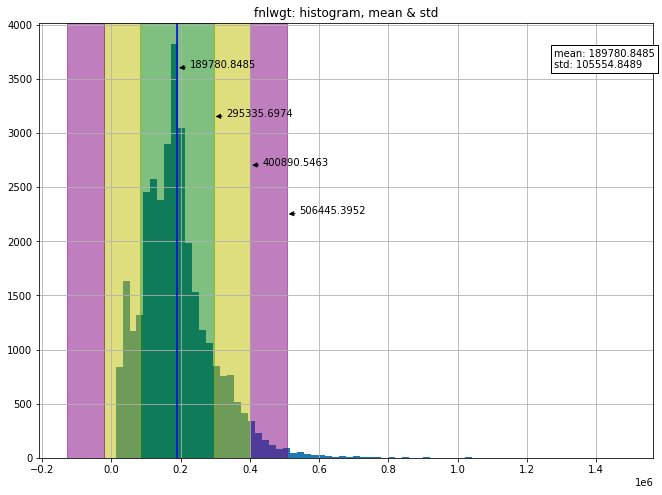

In [70]:
ax = exploratory.center_scale_plot(table.fnlwgt, np.mean, np.std, bins=73)

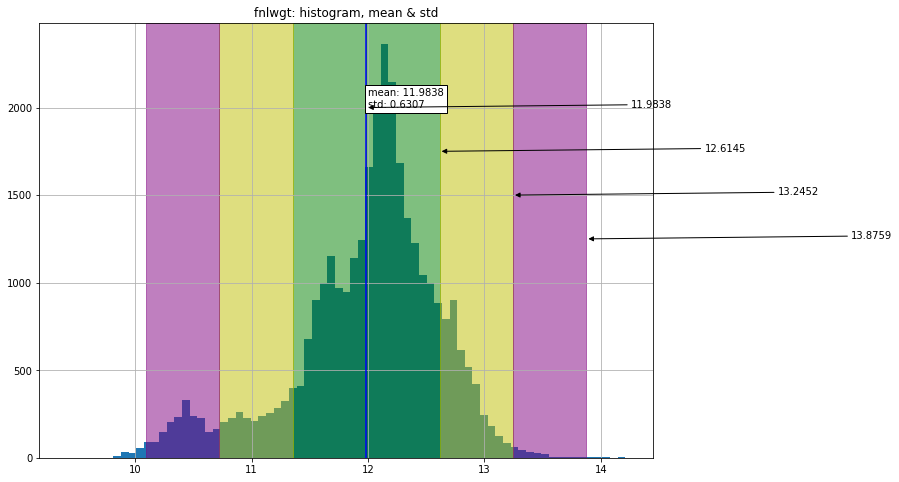

In [71]:
ax = exploratory.center_scale_plot(np.log(table.fnlwgt), np.mean, np.std, bins=73)

I don't know that we'll need this column, but let's go ahead and retain it anyway. Note that when creating a _new_ column, you must use the `table["column_name"]` notation and _not_ `table.column_name` notation:

In [72]:
table["age_log"] = np.log(table.age)

Let's take a look at a continuous column, `capital_gain`. We will do this through plotting a _histogram_, which we can do through the `DataFrame`'s `hist` method. Similar to before, I will set figure size, color, and a title. I will also tell it how many _bins_ to create.

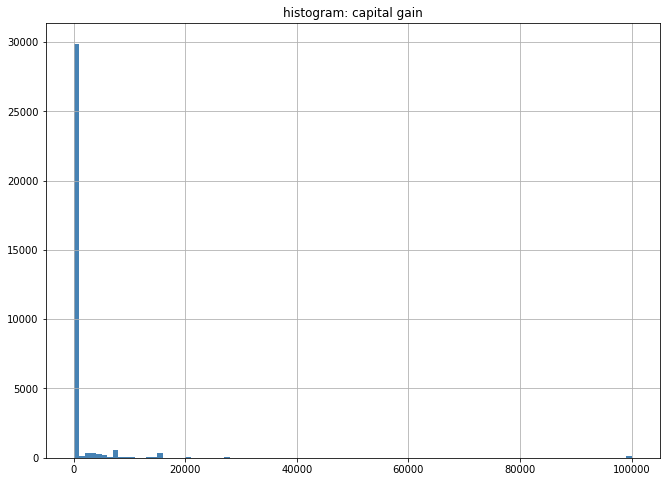

In [73]:
ax = table.capital_gain.hist(figsize=(11, 8), color="steelblue", bins=100)
ax.title.set_text("histogram: capital gain")

Wowza! How many people in this data set even have a non-zero capital_gain?

In [74]:
(table.capital_gain > 0).sum()

2712

So, less than 10% of the data. I wonder if a similar situation exists for `capital_loss`?

### --

### Problem

Determine the percentage of people in the data who have a non-zero value for `capital_loss`.

Then, confirm whether or not there is overlap between `capital_gain` and `capital_loss`. Hint: to check multiple conditions, each must be wrapped in its own set of paranetheses; you can use `|` for _or_ and `&` for _and_, depending on how you'd like to structure the conditions.

Next, create a new column, `capital_gain_net`, that combines the values in `capital_gain` and `capital_loss`. Visualize the results and do a quick write-up on what you have found. Feel free to home in on particular sections of the chart. 

### --

### Relational data analysis: the _group by_

Anyone who's done SQL before knows how valuable the _group by_ can be. 

For those unfamiliar, the basic idea is that you take column of categorical data, and group another column of data around it. Or, put differently, you bucket the other column's data based on what values that row takes for the first column. And then you apply some sort of aggregation function. 

Let's look at an example. Here, we'll look at average `capital_gain` when income is over $50K vs. when it's not:

In [80]:
table[["over_fifty_k_bool", "capital_gain"]
      ].groupby("over_fifty_k_bool"
      ).mean()

,capital_gain
over_fifty_k_bool,
False,148.884970
True,4007.164562


Interesting, or maybe, not? Folks earning over $50K per year had, on average, much higher capital gains. 

Let's throw standard deviation into the mix. First, we'll save our previous result into a new variable (I'm prefixing the variable name with an underscore so as to avoid cluttering the namespace):

In [81]:
_cap_gains_means = table[["over_fifty_k_bool", "capital_gain"]
                        ].groupby("over_fifty_k_bool").mean()

Next, let's rename the column so as to avoid ambiguity:

In [82]:
_cap_gains_means = _cap_gains_means.rename(
                            columns={"capital_gain": "capital_gain_mean"})

In [83]:
_cap_gains_means.columns

Index(['capital_gain_mean'], dtype='object')

Note that we could have achieved the same result by running: `_cap_gains_means.columns = ["capital_gain_mean"]`

Next, let's create the standard deviation result:

In [84]:
_cap_gains_std = table[["over_fifty_k_bool", "capital_gain"]
                        ].groupby("over_fifty_k_bool").std()

In [85]:
_cap_gains_std = _cap_gains_std.rename(
    columns={"capital_gain": "capital_gain_std"})

Finally, we can _join_ these tables together. For those unfamiliar, this is another important SQL concept in which we, using a common column (in this case, the row index), concatenate the columns of two (or more) tables together.

In [86]:
_cap_gains_means.join(_cap_gains_std)

,capital_gain_mean,capital_gain_std
over_fifty_k_bool,,
False,148.884970,963.557955
True,4007.164562,14572.097223


So, we have a much higher _average_ `capital_gain` with higher income, but also much more _volatility_. Let's quanitfy that on a relative basis.

In [87]:
_cap_gains_joined = _cap_gains_means.join(_cap_gains_std)

In [88]:
_cap_gains_joined["cap_gains_ratio"] = (
                                _cap_gains_joined.capital_gain_std /
                                _cap_gains_joined.capital_gain_mean
                            )

In [89]:
_cap_gains_joined

,capital_gain_mean,capital_gain_std,cap_gains_ratio
over_fifty_k_bool,,,
False,148.884970,963.557955,6.471828
True,4007.164562,14572.097223,3.636511


Interesting - *proportionately*, the low-income folks have more volatility.

Some **important** takeaways:
- always consider a mean alongside standard deviation
- thinking relatively (and thinking carefully about what your denominator is) can be very important

Do you think we could replicate this anlysis for our other numeric columns? Now, before we do that ... based on our knowledge of the data, we've (hopefully) noticed that `education` and `education_num` are, for all intents and purposes, identical - so let's kill one from `table`:

In [90]:
table[["over_fifty_k_bool", "capital_gain"]
      ].groupby("over_fifty_k_bool"
      ).agg(["mean", "std"])

capital_gain              
                          mean           std
over_fifty_k_bool                           
False               148.884970    963.557955
True               4007.164562  14572.097223

In [91]:
table = table.drop("education_num", axis=1)

### --

### Problem

Replicate the above group-by analysis, which we performed on `capital_gain`, on the other numeric columns in the data. Do this as programmatically as you can. Bonus points if you can figure out a way to measure the disparity between the results where `over_fifty_k` is `True`, and where it's `False`

### --

### Relational data analysis: _cross tabulations_

Can we do something similar for categorical data?

In [95]:
pd.crosstab(table.over_fifty_k_bool, table.marital_status).T

over_fifty_k_bool,False,True
marital_status,,
Divorced,3978,463
Married-AF-spouse,13,10
Married-civ-spouse,8280,6690
Married-spouse-absent,384,34
Never-married,10176,491
Separated,959,66
Widowed,908,85


The `pd.crosstab` function allows us to break down data into groups, based on the values the passed rows take for each of two columns, and returns the count for each group.

Let's save these results:

In [96]:
_cross_tabs = pd.crosstab(table.over_fifty_k_bool, table.marital_status).T

Get relative counts:

In [97]:
_cross_tabs = _cross_tabs / len(table)

Confirm our counts make sense:

In [98]:
_cross_tabs

over_fifty_k_bool,False,True
marital_status,,
Divorced,0.122261,0.014230
Married-AF-spouse,0.000400,0.000307
Married-civ-spouse,0.254480,0.205612
Married-spouse-absent,0.011802,0.001045
Never-married,0.312752,0.015091
Separated,0.029474,0.002028
Widowed,0.027907,0.002612


In [99]:
_cross_tabs.sum().sum()

1.0

Visualize results:

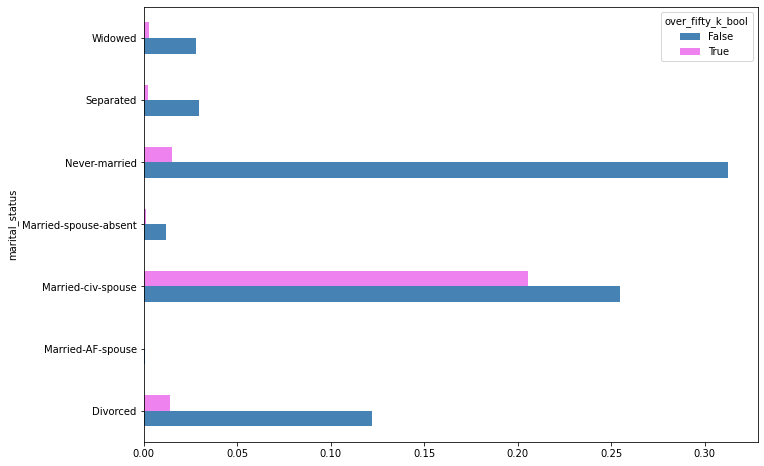

In [100]:
ax = _cross_tabs.plot.barh(figsize=(11, 8), color=["steelblue", "violet"])

Can we go even further, tabulating more than two columns? In fact, we can:

In [101]:
table[["over_fifty_k_bool", "marital_status", "sex"]
     ].groupby(["over_fifty_k_bool", "marital_status", "sex"]
     ).size().to_frame()

0
over_fifty_k_bool marital_status        sex         
False             Divorced              Female  2491
                                        Male    1487
                  Married-AF-spouse     Female     8
                                        Male       5
                  Married-civ-spouse    Female   903
                                        Male    7377
                  Married-spouse-absent Female   194
                                        Male     190
                  Never-married         Female  4594
                                        Male    5582
                  Separated             Female   614
                                        Male     345
                  Widowed               Female   779
                                        Male     129
True              Divorced              Female   179
                                        Male     284
                  Married-AF-spouse     Female     6
                                        Male       4
                  Married-civ-spouse    Female   754
                                        Male    5936
                  Married-spouse-absent Female    11
                                        Male      23
                  Never-married         Female   166
                                        Male     325
                  Separated             Female    17
                                        Male      49
                  Widowed               Female    46
                                        Male      39

Look at that monstrosity! Can we make it make a little more sense? Let's save it and give it a name:

In [102]:
_multi_tab = table[["over_fifty_k", "marital_status", "sex"]
                     ].groupby(["over_fifty_k", "marital_status", "sex"]
                     ).size().rename("size")

Using the `unstack` method, we can pop one of our row-level breakdowns into a columnar breakdown:

In [103]:
_multi_tab.unstack()

sex                                 Female  Male
over_fifty_k marital_status                     
<=50K        Divorced                 2491  1487
             Married-AF-spouse           8     5
             Married-civ-spouse        903  7377
             Married-spouse-absent     194   190
             Never-married            4594  5582
             Separated                 614   345
             Widowed                   779   129
>50K         Divorced                  179   284
             Married-AF-spouse           6     4
             Married-civ-spouse        754  5936
             Married-spouse-absent      11    23
             Never-married             166   325
             Separated                  17    49
             Widowed                    46    39

We can pick which level we pop out, too:

In [104]:
_multi_tab.unstack(0)

over_fifty_k                  <=50K  >50K
marital_status        sex                
Divorced              Female   2491   179
                      Male     1487   284
Married-AF-spouse     Female      8     6
                      Male        5     4
Married-civ-spouse    Female    903   754
                      Male     7377  5936
Married-spouse-absent Female    194    11
                      Male      190    23
Never-married         Female   4594   166
                      Male     5582   325
Separated             Female    614    17
                      Male      345    49
Widowed               Female    779    46
                      Male      129    39

And if we'd like to pop it back in:

In [105]:
_multi_tab.unstack(0).stack()

marital_status         sex     over_fifty_k
Divorced               Female  <=50K           2491
                               >50K             179
                       Male    <=50K           1487
                               >50K             284
Married-AF-spouse      Female  <=50K              8
                               >50K               6
                       Male    <=50K              5
                               >50K               4
Married-civ-spouse     Female  <=50K            903
                               >50K             754
                       Male    <=50K           7377
                               >50K            5936
Married-spouse-absent  Female  <=50K            194
                               >50K              11
                       Male    <=50K            190
                               >50K              23
Never-married          Female  <=50K           4594
                               >50K             166
                    

So, we could do this _all_ day (for many, many days...), but let's move on to feature selection. Before we go...

### --

### Problem

Think about the analyses we've performed and whether you wish we'd given any of them more time. Think about some more columns you might engineer out of the data we've got, and add _at least two_ new columns to `table`.

### --

# 3. Feature Selection

Choosing the right set of features can bring many benefits.

Some models don't work well with redundancy, so you'll want to choose features that are not too inter-related. Additionally, some datasets contain many, many columns, and reducing the amount of inputs to your model can drastically reduce the time it takes to prep your data and train your model. 

The benefits go on. In this case, we have a pretty simple feature set, but it will still help us to get a sense of what's the most predictive, which features overlap the most with other features, etc.

It should be noted that, when developing predictive models, you always need to be careful to *not base your performance benchmarks off of what you're training your models on*, and that goes even for feature selection - it's one thing to look at the entire dataset when you're exploring and looking for problems, but it's another to be programmatically making decisions around what to include in a model.

So we will start by taking 10% of our data out and putting it on the back burner - only for use at the very end, once we've already decided what our model and feature set are and once we're ready to just report performance estimates. We will take this 10% out _randomly_ and with respect to the _natural stratification_ of our target's clases (i.e. with respect for the balance of `True` / `False` in `over_fifty_k_bool`).

In [108]:
table.over_fifty_k_bool.value_counts(normalize=True)

False    0.759074
True     0.240926
Name: over_fifty_k_bool, dtype: float64

Here, we lean on `sklearn` for the random, stratified sampling:

In [109]:
train_inds, test_inds = train_test_split(table.index, test_size=.1, stratify=table.over_fifty_k_bool)

Next, we filter out any columns starting with `"over_fifty_k"` as we want to remove those from our feature set:

In [110]:
table_train = table.loc[train_inds, [c for c in table.columns if not c.startswith("over_fifty_k")]]

In [111]:
table_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'age_log',
       'capital_gain_net'],
      dtype='object')

We'll keep this as our `y`:

In [112]:
fifty_k_train = table.loc[train_inds, "over_fifty_k_bool"]

### Feature redundancy

Let's start with looking at feature redundancy. There are many ways to do this, and one approach is to leverage *Euclidean distance*, which, between two vectors $p$ and $q$ is $\sqrt{ \sum_{i}^n (q_{i} - p_{i})^2}$

You might recognize this from the Pythagorean Theorem and this is a generalization of that idea. We are solving for the distance of the straight line that exists between each of the pairwise combinations of features in the data, where each row represents a "dimension" of measurement.

See more [here](https://en.wikipedia.org/wiki/Euclidean_distance). 

I wrote my own function for this, and I thought we could try it out, even if only for conceptual purposes (you can see the code for this [here](https://github.com/lermana/indoorplants/blob/master/indoorplants/analysis/features.py)). The way this function works is: you pass it a DataFrame, and a selection of columns, and it computes pairwise distances between all the columns:

In [113]:
euclideans = features.euclidean_distances(table_train, 
                                         table_train.select_dtypes(include=[int, float, bool]).columns)

In [114]:
euclideans.shape

(21, 1)

So what are we looking for here? We want to find the features that are too "close" together (i.e. the value for `euclidean_distances` is small):

In [115]:
euclideans

euclidean_distances
feature_one    feature_two                          
capital_gain   age_log                     84.872728
capital_loss   age_log                     83.994809
age_log        capital_gain_net            78.716478
capital_gain   hours_per_week              71.171903
capital_loss   hours_per_week              70.374786
fnlwgt         age_log                     69.299014
hours_per_week capital_gain_net            64.635496
age            capital_gain                59.194857
               capital_loss                58.664838
fnlwgt         hours_per_week              53.974279
age            capital_gain_net            53.572150
               fnlwgt                      46.016356
               hours_per_week              41.515403
hours_per_week age_log                     41.069635
age            age_log                     28.347531
fnlwgt         capital_loss                26.913690
               capital_gain                26.296293
capital_loss   capital_gain_net            21.679578
fnlwgt         capital_gain_net            21.479598
capital_gain   capital_loss                20.875443
               capital_gain_net             6.970974

In [116]:
euclideans.describe()

,euclidean_distances
count,21.000000
mean,49.030278
std,23.303790
min,6.970974
25%,26.913690
50%,53.572150
75%,69.299014
max,84.872728


There are diffrent approaches we could take in deciding what is too small:
- pick some statistic (e.g. the `mean`, or the `25th percentile`) and use that as a cutoff
- create a histogram, and look for upper bound of the first "chunk"
- look at the data and take a more heuristic approach

I'm going to start by cutting a little above the mean and looking at everything below that value:

In [117]:
euclideans[euclideans.euclidean_distances < 60]

euclidean_distances
feature_one    feature_two                          
age            capital_gain                59.194857
               capital_loss                58.664838
fnlwgt         hours_per_week              53.974279
age            capital_gain_net            53.572150
               fnlwgt                      46.016356
               hours_per_week              41.515403
hours_per_week age_log                     41.069635
age            age_log                     28.347531
fnlwgt         capital_loss                26.913690
               capital_gain                26.296293
capital_loss   capital_gain_net            21.679578
fnlwgt         capital_gain_net            21.479598
capital_gain   capital_loss                20.875443
               capital_gain_net             6.970974

There are a couple of places that might make for a good cutoff point. Let's get a nice, pairwise view of everything under 50:

In [118]:
list(euclideans[euclideans.euclidean_distances < 50].index)

[('age', 'fnlwgt'),
 ('age', 'hours_per_week'),
 ('hours_per_week', 'age_log'),
 ('age', 'age_log'),
 ('fnlwgt', 'capital_loss'),
 ('fnlwgt', 'capital_gain'),
 ('capital_loss', 'capital_gain_net'),
 ('fnlwgt', 'capital_gain_net'),
 ('capital_gain', 'capital_loss'),
 ('capital_gain', 'capital_gain_net')]

There exist some more automated mechanisms we could use for choosing a cutoff point. But, based on the above analysis, I'd definitely consider killing:
- `capital_gain`
- `capital_loss`
- either `age` or `age_log`
- the boolean re-representations of `capital_loss`
- `fnlwgt`

`fnlwgt` is a statistical demographic measure that the government calculates, so it obviously shows up as related to a number of features. It seems close enough to `capital_gain_net` that I would kill it for now, especially since we don't really know what it is.

We can always add these columns back in later. (Let's preserve a copy with all columns before we start eliminating anything.)

In [119]:
table_train_copy = table_train.copy()

In [120]:
table_train = table_train.drop(["capital_gain", "capital_loss", "age_log", "fnlwgt"], axis=1)

In [121]:
table_train.shape

(29283, 11)

Now, why would one choose Euclidean distance to help with finding and eliminating redundant features? For one, the concept of "distance" works well when you have a combination of numeric and categorical data (as we do) and you're looking for a one-stop shop for eliminating redundant features.

Correlation is maybe a more commonly used measure, and it makes for a great fit for measuring the relatedness of numeric data. For categorical data, correlation doesn't really fit - even when categorical data does have a "direction" (e.g. `education_num` in our data) it might lack a proper sense of "magnitude" and what correlation measures is of course the strength _and_ direction of a relationship.

That said, let's work through how we would use correlation to eliminate certain features, as this could make for a good exercise:

In [122]:
corrs = table_train_copy.corr()

In [123]:
corrs

,age,fnlwgt,capital_gain,capital_loss,hours_per_week,age_log,capital_gain_net
age,1.000000,-0.075381,0.076077,0.060630,0.069258,0.980162,0.072609
fnlwgt,-0.075381,1.000000,0.001891,-0.011020,-0.020190,-0.073325,0.002472
capital_gain,0.076077,0.001891,1.000000,-0.031788,0.079022,0.080367,0.998581
capital_loss,0.060630,-0.011020,-0.031788,1.000000,0.053516,0.065949,-0.084976
hours_per_week,0.069258,-0.020190,0.079022,0.053516,1.000000,0.141692,0.075925
age_log,0.980162,-0.073325,0.080367,0.065949,0.141692,1.000000,0.076603
capital_gain_net,0.072609,0.002472,0.998581,-0.084976,0.075925,0.076603,1.000000


The correlation matrix above obviously contains redundant information, so let's grab a distinct set of correlation values, which we can achieve through some `numpy` magic. Let's get a representation of our row indices:

In [124]:
corr_rows = np.arange(corrs.shape[0])[:,None] 

In [125]:
corr_rows

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6]])

Now, let's get a representation of our column indices:

In [126]:
corr_cols = np.arange(corrs.shape[1])

In [127]:
corr_cols

array([0, 1, 2, 3, 4, 5, 6])

Now, we can create a boolean mask (as we've done above with thing like `table.duplicated()` or `table.age > 30`) through checking to see whether each value in `corr_rows` is greater than the corresponding value in `corr_cols`.

This mask will select only the *lower triangle* (so redundant values above are eliminated) and even further will not select the diagonal of the matrix. You'll see, shortly, why that's important.

Based on how we've set this up, `numpy` will automatically blow this out into a matrix represenation:

In [128]:
corr_mask = corr_rows <= corr_cols

In [129]:
corr_mask

array([[ True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False,  True]])

Now, why do we have `False` in the area that (as per the above description) we actually want to select? To be honest, I can't give you a great answer here, but this representation will get us to where we want to be.

In [130]:
corr_mask.shape

(7, 7)

In [131]:
corrs_unique = corrs.mask(corr_mask)

In [132]:
corrs_unique

,age,fnlwgt,capital_gain,capital_loss,hours_per_week,age_log,capital_gain_net
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,-0.075381,NaN,NaN,NaN,NaN,NaN,NaN
capital_gain,0.076077,0.001891,NaN,NaN,NaN,NaN,NaN
capital_loss,0.060630,-0.011020,-0.031788,NaN,NaN,NaN,NaN
hours_per_week,0.069258,-0.020190,0.079022,0.053516,NaN,NaN,NaN
age_log,0.980162,-0.073325,0.080367,0.065949,0.141692,NaN,NaN
capital_gain_net,0.072609,0.002472,0.998581,-0.084976,0.075925,0.076603,NaN


Now we have a correlation matrix with no redeundant values and no diagonal. Why? So that we can get an ordered view that allows us to remove the most-correlated features.

In [133]:
corrs_unique.unstack().rename("correlation").abs().to_frame().sort_values("correlation", ascending=False).head(10)

correlation
capital_gain   capital_gain_net     0.998581
age            age_log              0.980162
hours_per_week age_log              0.141692
capital_loss   capital_gain_net     0.084976
capital_gain   age_log              0.080367
               hours_per_week       0.079022
age_log        capital_gain_net     0.076603
age            capital_gain         0.076077
hours_per_week capital_gain_net     0.075925
age            fnlwgt               0.075381

To compare this to the above Euclidean distance method, notice that our very-correlated features line up with what we'd already slated for removal. But, note that some features that we found to be "close" are not necessarily *correlated* - interesting, isn't it?

Remember that when people say "correlation" they are generally referring to *Pearson's correlation coefficient* ([wikipedia](https://en.wikipedia.org/wiki/Correlation_and_dependence#Pearson's_product-moment_coefficient)). To understand how that works, let's first look at [covariance](https://en.wikipedia.org/wiki/Covariance):

$$ cov(X, Y) = E[(X - E[X])(Y - E[Y])] $$

In English, that's:
1. take `X`, and subtract its mean from each of its value
2. take `Y`, and subtract its mean from each of its value
3. take the product of 1. and 2.
4. take the mean of 3.

Let's think about how that works ...

If $X_{1} - E[X]$ is negative, but $Y_{1} - E[Y]$ is positive, the product of that will be negative. If they're both positive, the product is positive; same for if they're both negative. That's how "direction" plays in here. As for "magnitude", the bigger the difference between `X` and its mean tends to be, the bigger the *covariance* between X and anything else; ditto for `Y`.

Finally, to get correlation from covariance, we scale by the product of the standard deviations of `X` and `Y`, which keeps the result between -1 and 1:

$$ corr(X, Y) = \frac {cov(X, Y)}{\sigma_X \sigma_Y}$$

### Feature Selection

Now, let's get into picking the _good_ features. 

To do this, we're going to need to do a little data prep. This data prep entails _one-hot_ (or *dummy*) encoding our `object` columns. 

What this entails is taking a single column of categorical data and converting it into a number of columns - as many columns as there are values for the categorical variable - of boolean data, with a each column representing a particular categorical value.

Let's look at an example:

In [134]:
table_train.sex.head()

13222      Male
19389      Male
27346      Male
816      Female
31643      Male
Name: sex, dtype: object

In [135]:
pd.get_dummies(table_train.sex.head())

,Female,Male
13222,0,1
19389,0,1
27346,0,1
816,1,0
31643,0,1


So instead of five rows, each containing `"Female`" or `"Male"` we now have five rows, each containing a `1` in the `Male` and `0` in the `Female` column if `sex="Male"`, or vice versa if  `sex="Female"`.

Note that there does not have to be mutual exclusivity between the columns that result from a one-hot encoding. If there _is_ mutual exlusivity, it is good practice to drop one of your resulting columns, lest you introduce some redundancy into your feature set. E.g. we wouldn't want to represent `over_fifty_k` with two columns `over_fifty_k` and `equal_to_or_under_fifty_k`, right?

In this case, we're going to quickly iterate through each `object` column, perform the encoding, and drop one of the resulting columns. We're also going to prefix each of our resulting columns with the name of the column that the value originall came from, to avoid possible name collisions:

In [136]:
_one_hots = [
                pd.get_dummies(
                    table_train[col],
                    drop_first=True,
                    prefix=col
                )
             for col in table_train.select_dtypes(include=object).columns]

Now we have a list of `pd.DataFrame` objects - let's spot-check the first one:

In [137]:
_one_hots[0].iloc[:3, :3]

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked
13222,0,0,0
19389,0,0,0
27346,0,0,0


How do we join these dataframes together? One way to do that is through joining the first to the rest:

In [138]:
one_hot_df = _one_hots[0].join(_one_hots[1:])

In [139]:
one_hot_df.shape

(29283, 94)

In [140]:
one_hot_df.iloc[:5, :5]

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc
13222,0,0,0,1,0
19389,0,0,0,1,0
27346,0,0,0,1,0
816,0,0,0,1,0
31643,0,0,0,0,0


Now we can create our `X` and `y` variables. For `X`, we'll join the one-hot columns to our numeric data: 

In [141]:
X = one_hot_df.join(table_train.select_dtypes(include=[int, float]))

In [142]:
X.shape

(29283, 97)

In [143]:
table_train.dtypes.value_counts()

object    8
int64     3
dtype: int64

You can see that we have no more `object` columns:

In [144]:
X.dtypes.value_counts()

uint8    94
int64     3
dtype: int64

For `y` (which we typically lowercase to indicate that it is not a matrix but a vector), we don't have to do any prep:

In [145]:
y = fifty_k_train

Next, we're going to create a _Random Forest Classifier_. What's that mean? Let's break it down.

--

### Some Theory

**Classification**

For starters, a [classifier](https://en.wikipedia.org/wiki/Statistical_classification) is a model that predicts a class or label, as opposed to a numeric value - i.e. it's built for predicting categorical data. In this case, we're going to, for all intents, restrict our definitions to [binary classification](https://en.wikipedia.org/wiki/Binary_classification) (where our target, what we're predicting, can only take one of two values). 

**Decision Tree Learning**

A _Decision Tree_ [is](https://en.wikipedia.org/wiki/Decision_tree_learning) a model that builds a series of rules, kind of like the game _twenty questions_. E.g is `age >= 15`? It typically does this repeatedly until it has created a number of *pure* (or close to it) "leaves" or terminal nodes such that each of these nodes strongly represents a particular class value. In more detail, we train a decision tree through, basically:
- iterating through the available features and the available values for each of those features
- evaluating the effectiveness of each of those feature values when it comes to splitting the data into groups that represent a particular class
- selecting the most effective feature-value rule (e.g. `age >= 30`) or "splitting rule" and splitting the data based on that rule
- we then apply the same process to each of the resultant groups (e.g. `age >= 30` and `age < 30`) and continue doing so until we have found our "pure" nodes

What is a pure node? The idea is that, once our tree is built (i.e. trained), we can make a prediction through propagating a data point through the rules in the tree (e.g. `age >= 30`, `sex == Female`) until we've reached a partition of the data that, in our training, we found to be associated with one particular class. We then return the class associated with our final partition as our "prediction."

What's been described has been maybe a little bit simplified but should provide a good idea of the foundational concepts.

**Splitting Rule Evaluation**

Purity here refers to the distributional concentration of the data towards a particular class. Put differently, we can think about the probability of how often a randomly chosen item would be mislabeled, if all we had to go off was the class probabilities across the entirety of the given data. To calculate this number, we must account for the following:
- probability of drawing a random item with a certain class label (let's call this `p`)
- probability that this data will have come from another class (this is in fact `1 - p`)

(this is of course assuming that a given data point can belong to exactly one class.) Since these two conditions are independent, we simply multiply them together, yielding:

$$ p \cdot (1 - p) $$

and at a given node, we can sum this result across all classes to get what's called [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), which provides a good measure for the effectiveness of a given splitting rule in partitioning the data according to its class labels. Now that we have a good measure for splitting rule effectiveness, we can choose our splitting rule such that it provides the greatest reduction in impurity from the previous node.

Note that our impurity function is concave, with a maximum when class probabilities are equal, and a minimum when all except for one class's probabilities are zero. I.e. nodes are the least pure when they consist of an equal proportion for each class, and nodes are the purest when they contain only one class, and the more a rule leads us to more pure nodes, the better the rule.

**Tree Depth**

If we let a decision tree grow, uninhibited, until all of its leaves are pure, we will likely end up with a tree that has *overfit*, i.e. it is so tightly coupled to the data it was trained on that it won't generalize well. Thus, we will often implement something to prevent the tree from becoming too deep, through setting something like a specific number of levels that a tree can't exceed, or a minimum number of items that can end up in a leaf / terminal node.

**Random Forest**

So what's a *Random Forest*? The idea is that, in trying to prevent overfitting, we build a whole bunch of decision trees, such that each tree is a little bit different, and take the average across all these trees' votes to produce a prediction.

In a little more detail, a [random forest](https://en.wikipedia.org/wiki/Random_forest) generally relies on the following procedures in order to ensure that there is *variance* across its trees' structures:
- each tree is based off its own [bootstrap sample](https://en.wikipedia.org/wiki/Random_forest#Bagging), or random resampling with replacement, of the underlying data
- a random subset of the available features will be used each time a new splitting rule is to be defined

It's worth noting that random forests are models for which it is desirable to limit redundancy in features, as redundant features will limit the effectiveness of creating a number of different trees using random subsets of the feature space.

--

So, what are going to use a random forest for? We're actually going to build a machine learning model, and retrain it to different subsets of the feature space, and use feature contributions to help us determine what our most useful features are.

We're going to set this forest to build 10 trees (in practice, it's good to use 100), and pass another argument for `class_weight`, which we'll get to in a bit:

In [146]:
rf = RandomForestClassifier(n_estimators=10, class_weight="balanced")

Now, we'll use something called the *recursive feature eliminator* (`RFE`) to help us determine which features are worth keeping. In practice, [permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html) is the preferred method for this, but the `RFE` is kind of an intuitive and interesting trick to see.

The way the `RFE` works is as follows:
- we pass it a model to use (in our case, `rf`) as well as the number of features we're looking to keep (in our case, `10`)
- then, we fit it to some data
- from there, it will evaluate the effectiveness of each feature, and it will eliminate the least effective feature
- it will then continue this process, [recursively](https://en.wikipedia.org/wiki/Recursion_(computer_science)) (hence its name), until the desired number of features remain

How does it determine the effectiveness of each feature? It actually leans on the inputted model for that, and what the random forest uses is Gini impurity - it will look across each split in each of its trees, sum up the reductions to impurity, by feature, and return these results.

Now, why is *permutation importance* preferred? Because relying on Gini to interpret features can lead to results that favor features with a high [cardinality](https://en.wikipedia.org/wiki/Cardinality). But, the interpretability of tree-based models is interesting and is worth learning about, and we'll work with that method here.

In [147]:
selector = RFE(rf, 10)

In [148]:
selector.fit(X, y)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight='balanced', criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=10, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=10, step=1, verbose=0)

These are the top 10 columns that were selected:

In [149]:
sorted(list(X.columns[selector.support_]))

['age',
 'capital_gain_net',
 'education_Bachelors',
 'education_HS-grad',
 'hours_per_week',
 'marital_status_Married-civ-spouse',
 'marital_status_Never-married',
 'occupation_Exec-managerial',
 'occupation_Prof-specialty',
 'sex_Male']

In [150]:
good_cols = sorted(list(X.columns[selector.support_]))

In [151]:
ranks = pd.DataFrame(
    list(zip(X.columns, selector.ranking_)), 
    columns=["column_name", "rank_survived_until"]
                     ).sort_values("rank_survived_until")

Let's look at the 10 worst:

In [152]:
ranks.iloc[-10:]

,column_name,rank_survived_until
7,workclass_Without-pay,79
59,native_country_Ecuador,80
81,native_country_Peru,81
77,native_country_Laos,82
80,native_country_Outlying-US(Guam-USVI-etc),83
89,native_country_Thailand,84
30,occupation_Armed-Forces,85
2,workclass_Never-worked,86
68,native_country_Honduras,87
67,native_country_Holand-Netherlands,88


Let's retain these particularly bad ones and drop them out of our data:

In [153]:
crummy_features = ranks.iloc[-10:].column_name

In [154]:
X = X.drop(crummy_features, axis=1)

# 3. Machine Learning

Let's build a model, and let's evaluate it (at least somewhat) properly.

### Class imblanace

One thing I cannot stress enough is the need to keep in mind the balance of the classes in the data you have. For example, let's say I start with the following model, which will simply return `0` (i.e. `False`) for each row in the inputted `X`:

In [155]:
def crummy_model(X):
    return np.zeros((len(X),))

In [156]:
y_pred = crummy_model(X)

In [157]:
accuracy_score(y, y_pred)

0.7590752313629068

What?! All we did we literally return 0 for every value! How is our accuracy so good?

In [158]:
y.value_counts(normalize=True)

False    0.759075
True     0.240925
Name: over_fifty_k_bool, dtype: float64

Wait a second ... that's a perfect match for the natural distribution of classes in the data. And now you've seen the danger of class imblanace - when you have more of one class than the other, if you just always pick the _majority_ class, you'll have a model that looks decent (at least if you are using "accuracy" to evaluate it).

This is what the `class_weights` argument to our model is for - it tells the forest to build each tree based off a _class-balanced_ subset of the data.

### Scores

So, how do protect ourselves, aside from setting the right model parameters, against falling into that sort of trap?

The above example showed that accuracy, though a nice thumb-in-the-air sort of metric, and also a metric that lots of managers will enjoy discussing, can be pretty dangerous to use. There are better scores, for sure, but one thing you can always do with your prediction results is *look* at them, rather than just rolling them up into a score.

Enter the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), whose rows represent the actual class value and whose columns represent the predicted class value. `sklearn` implements this for us, and we will wrap their function to better format the results:

In [159]:
def get_confusion(y, y_pred):
    # with score functions, especially in sklearn, we always pass y or y_true and then y_pred
    matrix = confusion_matrix(y, y_pred)
    
    df = pd.DataFrame(matrix,
                     index=["negative_actual", "positive_actual"],
                     columns=["negative_predicted", "positive_predicted"])
    
    return df

In [160]:
get_confusion(y, y_pred)

,negative_predicted,positive_predicted
negative_actual,22228,0
positive_actual,7055,0


Looking at the above, we can see clearly that all our model did was predict `negative`.

A little bit more on the confusion matrix: the diagonal (i.e. positions `(0,0)` and `(1, 1)`) hold the correct predictions. Points falsely predicted as positive are known as *false positives* (FP), and points correctly predicted as positive are known as *true positives* (TP) - the same nomenclature holds on the negative side.

We can get *accuracy* score from the above through taking the following ratio:

$$ accuracy = \frac {TP + TN}{TP + TN + FP + FN}$$

i.e. we take the number of correct predictions (or predictions on the diagonal) and divide that by the total number of predictions. But we can get some more nuanced measures here, too. If the above is our overall accuracy, what if we broke that down into two, let's say this colloquially, components? For instance:
1. a model's carefulness
2. a model's thoroughness

How might we calculate these scores? Maybe for "carefulness," we could do:

$$ precision = \frac{TP}{TP + FP}$$

The above is the ratio of correct, positive predictions to the number of total positive predictions - i.e. of all the times the model predicted *positive*, what proportion of those predictions were correct? Maybe for "thoroughness," we could do:

$$ recall = \frac{TP}{TP + FN} $$

The above is the ratio of correct, positive predictions to the number of total actual positive values - i.e. out of all the actual positive values in the data, what proportion did the model correctly identify?

Which you might use depends on what you trying to solve for, and what the consequences of different types of mistakes are. It's almost like different styles of poker players - some bet carefully, preserving their bankroll, while some bet aggressively, not wanting to miss an opptortunity to make money. Or, for another example, it could be like talking to people at a cocktail party - do you want to speak only to people who you think have a good chance of responding to you, or do you want to speak to as many people as possible?

And, interestingly, there's a [tradeoff](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) between precision and recall - lower your decision threshold and you'll identify more positives (higher recall) less precisely (i.e. with more false positives). Often times you want to account for both precision *and* recall, and there a number of other scores one can look to in evaluating a predictive model. For instance, the [f1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) is the harmonic mean of precision and recall.

For now, the 3 scores we've covered, along with the confusion matrix, should provide a great starting point.

### Cross-validation

So how do we actually evaulate our models? We generally:
- pick some kind of scoring metric
- run several trials using different samples of the data
- take the aggregate (usually the *mean*) score across these trials as our meeasure of model performance

There are some mechanics to how we achieve this. The standard, applicable to many problems, is [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). In cross-validation, we break the data into chunks or "folds" - for the sake of example, let's say 5. We take 4 of those folds and use them to train a model, and test that model on the other fold (or "hold-out" or "test" fold). Then, we repeat that process, inserting the previous test fold back into the train set, and taking a different train fold out as the test set. We do this until we've tested on all 5 folds and then typically report the average (and maybe standard deviation) performance across these folds.

Some additional details:
- cross validation (CV) is often referred to as *k-fold cross validation*, where `k` represents the number of folds used (in the above example, 5)
- the data is typically sampled randomly into the k folds
- in classification, [stratified](https://en.wikipedia.org/wiki/Stratified_sampling) random sampling is used, such that the given class distributions are preserved within each fold

So, this whole process is kind of like what we did above, with our "hold-out" set that we're using for our final, reported performance estimates, except that we are repeating the process several times. Why?
- we can evaluate the model's performance across every provided data point (as we test on every fold)
- we avoid ever evaluating the model's results on the data that it was trained it on

Finally, why the exterior or initial 90 / 10 breakdown, in addition to CV? That's because we use CV for making decisions like:
- which features to use
- which model to use
- how to tune that model

and we want to have fresh data to report our final estimates on that was not used as part of the feature or model selection processes. Let's try this out! We'll use the implementation from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html):

In [161]:
rf = RandomForestClassifier(n_estimators=10, class_weight="balanced")

Accuracy:

In [162]:
accs = cross_val_score(rf, X, y, scoring=make_scorer(accuracy_score), cv=5)

In [163]:
np.mean(accs), np.std(accs)

(0.8393267921901867, 0.00481228812150118)

Precision:

In [164]:
precs = cross_val_score(rf, X, y, scoring=make_scorer(precision_score), cv=5)

In [165]:
np.mean(precs), np.std(precs)

(0.6954928049750633, 0.012904388774531662)

Recall:

In [166]:
recs = cross_val_score(rf, X, y, scoring=make_scorer(recall_score), cv=5)

In [167]:
np.mean(recs), np.std(recs)

(0.6063784549964564, 0.009567420003223918)

So our accuracy is way higher than our precision, which is also a good bit higher than our recall - this large disparity amongst scores can be a good indicator that a model is not fitting to the data well.

### Hyper-parameter tuning

An obvious goal when selecting the model is to avoid *underfitting* - i.e. we want our model to fit the data well. But, as mentioned before, we also want to avoid *overfitting*, or building a model that is too tightly coupled to the data it's trained on.

There's actually a great concept that encapsulates this relationship, and that's the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). The idea is that, generally speaking, there's a tradeoff between a model being correct and a model being consistent. A model that will, at least on some data, predict certain data with high accuracy may offer much worse performance on other data (i.e. there's "variance" in its performance). On the other hand, a model that is restricted from building a tight fit to any particular data may produce predictions that are wrong (or "biased").

We evaluate fit by comparing our train scores to the test scores. In other words, in addition to retaining performance on each of our hold out sets, we also retain performance when predicting the data the model is trained on. We must **never** report train scores, but they can prove useful when compared to test scores. If there's a large disparity - let's say, greater than 5% - then the model is likely overfitting.

How do we handle that? Most models have some *hyper-parameters* - parameters you pass to the model creation process, as opposed to the data that you pass to the model fitting proces - that will restict a model from establishing too tight of a fit. With *logistic regression*, you can control [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) in order to force the model's coefficients to stay near 0. With a random forest, you can control the [depth of a tree](https://en.wikipedia.org/wiki/Decision_tree_pruning).

In [168]:
results = cross_validate(rf, X, y, scoring=make_scorer(recall_score), cv=5, return_train_score=True)

In [169]:
results_train = pd.Series(results["train_score"], name="train")

In [170]:
results_test= pd.Series(results["test_score"], name="test")

In [171]:
results_train.to_frame().join(results_test)

,train,test
0,0.939050,0.614458
1,0.940291,0.606662
2,0.942948,0.587527
3,0.935684,0.621545
4,0.937633,0.598157


We can see quite a disparity here! I wonder what will happen if we limit tree depth?

In [172]:
rf_depth = RandomForestClassifier(n_estimators=10, class_weight="balanced", max_depth=16)

In [173]:
results = cross_validate(rf_depth, X, y, scoring=make_scorer(recall_score), cv=5, return_train_score=True)

In [174]:
results_train = pd.Series(results["train_score"], name="train")

In [175]:
results_test= pd.Series(results["test_score"], name="test")

In [176]:
results_train.to_frame().join(results_test)

,train,test
0,0.921687,0.840539
1,0.924876,0.851878
2,0.924699,0.833451
3,0.919029,0.841247
4,0.920801,0.851878


Wow - a big difference! By the way, if we wanted to evaluate based on limiting the size of the leaves in the trees, as opposed to explicitly limiting the depth of the tree, you could tweak the `min_samples_leaf` hyper-parameter. These methods are probably pretty comparable in practice but maybe offer different interpretations, each of which might fit certain datasets or problems better.

A good tecnhique is to evaluate a model's performance over different hyper-parameter values. `sklearn` has [implemented](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) something called `GridSearchCV`, which will perform an exhaustive search over the different parameter values you pass. This is a great tool, and makes setting up automated build pipelines much easier.

However, in the analysis stage, it can be worthwhile to actually *look* at results. `indoorplants` offers `matplotlib` wrappers for some of the `sklearn` functionality to allow for visualizing CV over different hyper-parameter values.

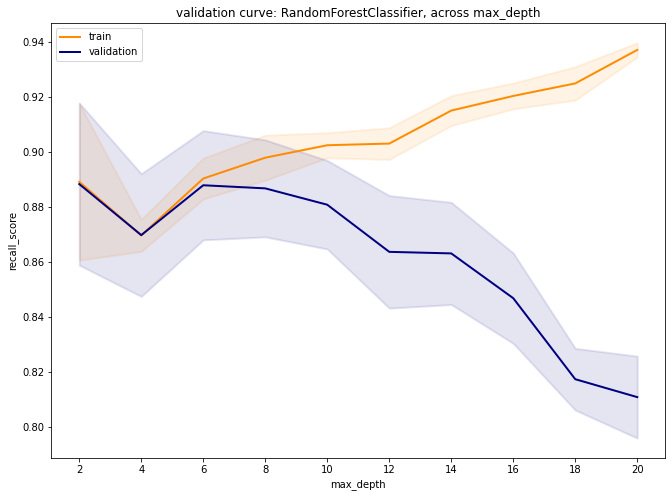

In [177]:
curves.validation_curve(X, y,
                        score=recall_score,
                        model_type=RandomForestClassifier,
                        param_name="max_depth",
                        param_range=[2*n for n in range(1, 11)],
                        other_params={"n_estimators": 10, "class_weight": "balanced"})

Here we can see the overfitting quite clearly - look how the train and test scores separate as tree depth increases! It looks like `max_depth=12` might offer a good balance. Now, we can also consider precision, and a good way to compare precision to recall is through looking at a *precision-recall curve*:

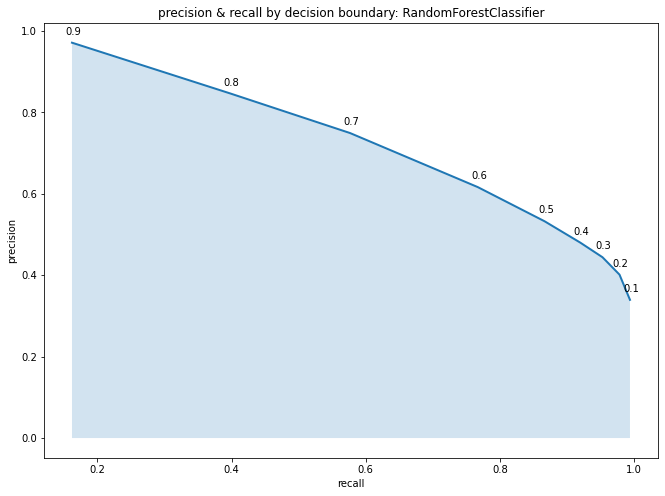

In [178]:
curves.precision_recall_curve(
                        X, y,
                        model_type=RandomForestClassifier,
                        model_params={"max_depth": 12, "n_estimators": 10, "class_weight": "balanced"}
                )

The numbers above the line represent the [decision threshold](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/), or the score at which our model will make a positive classification. See, the way most classifiers work is they actually produce some kind of "score" that is then rolled up into the prediction of a "label" or class.

For some models these scores can be considered sound probability estimates, as with logistic regression classifiers. Random forests do a pretty good job with scores (i.e. they tend to be pretty well [calibrated](https://www.svds.com/classifiers2/).

You can see that, as we lower our decision threshold, we increase our recall at the expense of our precision. Based on what we're seeing I might set our decision threshold at 65% or .65 - the default is typically 50%. This step is not always necessary but can prove helpful when classes are imbalanced (as ours are, although the 3:1 class ratios we have are not that severe). This is generally a step you'd take in a pretty imblanced problem after you had put some effort into model tuning.

### Model Selection, Additional Details

There are many models to choose from, with each providing its own strengths and weaknesses.

Simpler models lead to reduced odds of overfitting, quicker build times, and easier debugging when problems occur. For example, [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=Logistic%20regression%20is%20a%20statistical,a%20form%20of%20binary%20regression), which basically entails wrapping a linear regression model with the *logit* function (squashing output to be between 0 and 1 so that it can be interpreted as a probability), is considered a very simple model. As an added bonus, if you need to go beyond class labels and into class probabilities, logistic regession naturally does a great job there.

Complex models, while sometimes useful or even necessary, can bring the burdens of potential overfitting, more hyperparameters to tune, longer train times, and more complicated debugging procedures. They can sometimes deliver much stronger results (see: the world of [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network)). Often it comes down to bias & variance: would you rather have your model be wrong, but conistent, or sometimes very right and sometimes very wrong? Generally, it's somewhere in between.

Now, data preparation plays a part, too. With any model that involves taking a linear combination of features (e.g. logistic regression, or the internals of a [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)), pre-treating continuous data so that its values are [normalized](https://en.wikipedia.org/wiki/Feature_scaling) (to be between 0 and 1) is very important. So is reducing skewness. Additionally, you must worry about outliers. And of course, missing data.

With a random forest, you do not need to worry about feature scaling or skewness. You also don't really need to worry about outliers (since the tree works through splitting, and not multiplying and adding). Ditto for missing data, as long as you encode it correctly. That's not to say that you shouldn't have an understanding of the source of your data quality issues, just that you don't have to worry about coding around them.

So, RF models take some of the fun out of creative data prep, but they take some of the work out, too!

### --

### Problem

Your turn - find the "best" model you can. This means you need to:
- pick a score function to use
- pick a subset of the feature space to use
- pick the model hyper-parameters to use

Try out different combinations of features to see if you get anything that's noticeably better. For those of you who have done this before, please feel free to try additional models.

### --

### Final performance estimation

Once we've done _everything_ we'd like to do for our model evaulation, we can use our selected model to predict the _hold-out_ set that we saved earlier. We'll build our `X` and `y` as we did before.

In [179]:
def is_y_col(c):
    return c != "over_fifty_k"

In [180]:
[c for c in table.columns if is_y_col(c)]

['age',
 'workclass',
 'fnlwgt',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'over_fifty_k_bool',
 'age_log',
 'capital_gain_net']

In [181]:
table_test = table.loc[test_inds, [c for c in table.columns if c != "over_fifty_k"]]

In [182]:
fifty_k_test = table.loc[test_inds, "over_fifty_k_bool"]

In [183]:
table_test = table_test.drop(["capital_gain", "capital_loss", "age_log", "fnlwgt"], axis=1)

In [184]:
_one_hots = [
                pd.get_dummies(
                        table_test[col], drop_first=True, prefix=col
                    )
             for col in table_test.select_dtypes(include=object).columns
        ]

In [185]:
one_hot_df_test = _one_hots[0].join(_one_hots[1:])

In [186]:
one_hot_df_test.shape

(3254, 89)

In [187]:
X_test = one_hot_df_test.join(table_test.select_dtypes(include=[int, float]))

In [188]:
X_test.shape

(3254, 92)

Now, we must make sure that the columns of `X_test` line up with those of the `X` that we trained on.

In [189]:
set(X_test.columns) - set(X.columns)

{'native_country_Ecuador',
 'native_country_Honduras',
 'native_country_Laos',
 'native_country_Outlying-US(Guam-USVI-etc)',
 'native_country_Peru',
 'native_country_Thailand',
 'occupation_Armed-Forces'}

So, `X_test` has some columns that `X` doesn't (remember that we dropped some columns during feature selection).

In [190]:
set(X.columns) - set(X_test.columns)

{'native_country_Hungary', 'native_country_Yugoslavia'}

Whoa, why does `X` have columns `X_test` doesn't? Because our one-hot features in each table were created on subsets of the data (train and test), we probably have some categorical values that were present in `test` but not `train`. 

So, we'll drop anything in `X_test` that's not in `X`, and we'll also add `0` columns for anything `X_test` is missing (i.e. we'll create new, one-hot columns but since we know the values were missing, we can just set them to `0` or `False`).

In [191]:
X_test = X_test.drop(list(set(X_test.columns) - set(X.columns)), axis=1)

In [192]:
for c in set(X.columns) - set(X_test.columns):
    X_test[c] = 0

In [193]:
X_test.shape

(3254, 87)

In [194]:
y_test = fifty_k_test

In [195]:
y_test.value_counts(normalize=True)

False    0.759066
True     0.240934
Name: over_fifty_k_bool, dtype: float64

Now, we can train our model:

In [196]:
rf = RandomForestClassifier(max_depth=12, class_weight="balanced", n_estimators=10)

In [197]:
rf = rf.fit(X, y)

Let's predict our hold-out data:

In [198]:
y_pred = rf.predict(X_test)

And finally, let's evaluate:

In [199]:
for score in (accuracy_score, precision_score, recall_score):
    print(f"{score.__name__}: ", score(y_test, y_pred))

accuracy_score:  0.7768899815611555
precision_score:  0.6883116883116883
recall_score:  0.13520408163265307


In [200]:
get_confusion(y_test, y_pred)

,negative_predicted,positive_predicted
negative_actual,2422,48
positive_actual,678,106


So, how'd we do? Our model looks okay but is proving to be overly cautious in making positive predictions. I.e., our recall is too low / we have too many false negatives. This is a pretty common occurence in imblanaced problems - we simply have less positive instances to learn from, so our model doesn't predict as many of them as it should.

Some potential [improvements](https://www.svds.com/learning-imbalanced-classes/):
- change `class_weight` from `"balanced"` to something that explicitly favors the positive class
- contrary to what's been discussed above, make the decision threshold *lower* - this will help with recall
- resample the data to artificially create class balance (through removing negative instances or duplicating positive instances)

Of course, this is our reporting run, so we don't want to use this for tuning, selection, etc. If you end up in this type of situation, take it as a nudge to go back to validation and really work things out (in this case, validating over different `class_weight` values is the easiest step) and then, once you've made a final decision, generate reporting estimates and call it a day!